In [1]:
import numpy as np
import torch
import gif
import matplotlib.pyplot as plt
import pytorch_lightning as pl 
from pathlib import Path
import yaml
import matplotlib.ticker as ticker
import matplotlib.colors as colors

from matplotlib.tri import Triangulation as triang

from scipy.io import loadmat

from scipy.interpolate import LinearNDInterpolator as interp_lin

from core.autoencoder import AutoEncoder
from core.unstructured_data import DataModule

import seaborn

seaborn.set_style("darkgrid")

In [3]:
#### Change the entries here to analyze a new model / dataset
experiment_name = 'flow_maxskip_qcnn_500'
model_checkpoint_path = Path('C:\\Users\\Kevin\\Google Drive\\Research\\QCbranch\\QuadConv\\lightning_logs\\flow_maxskip_qcnn_500\\lassen_version_0') / 'checkpoints'
input_shape = (1,1,7613)
###################

checkpoint = list(model_checkpoint_path.glob('epoch=*.ckpt'))

print(model_checkpoint_path)
print(checkpoint)

print(f'Loading experiment {experiment_name} and {checkpoint[0]} ')

experiment_path = Path('../experiments/')
model_yml = list(experiment_path.rglob(experiment_name + '*'))

with model_yml[0].open() as file:
    config = yaml.safe_load(file)

config['data']['data_dir'] = 'C:\\Users\\Kevin\\Google Drive\\Research\\QCbranch\\QuadConv\\data\\FlowCylinder'

module = config['data'].pop('module')
data_module = DataModule(**config['data'])
data_module.setup(stage='analyze')
dataset, locations = data_module.analyze_data()

#TODO Make a dataloader option that outputs 1 experiments worth of data

model = AutoEncoder.load_from_checkpoint(checkpoint[0], input_shape=input_shape, **config['model'])
model.eval()
model.to('cpu')

C:\Users\Kevin\Google Drive\Research\QCbranch\QuadConv\lightning_logs\flow_maxskip_qcnn_500\lassen_version_0\checkpoints
[WindowsPath('C:/Users/Kevin/Google Drive/Research/QCbranch/QuadConv/lightning_logs/flow_maxskip_qcnn_500/lassen_version_0/checkpoints/epoch=5206.ckpt')]
Loading experiment flow_maxskip_qcnn_500 and C:\Users\Kevin\Google Drive\Research\QCbranch\QuadConv\lightning_logs\flow_maxskip_qcnn_500\lassen_version_0\checkpoints\epoch=5206.ckpt 
torch.Size([1, 16, 1600])
HACKY FIX
Using a grid: True
HACKY FIX
Using a grid: True
HACKY FIX
Using a grid: True
HACKY FIX


AutoEncoder(
  (loss_fn): MSELoss()
  (output_activation): Tanh()
  (encoder): Encoder(
    (activation1): CELU(alpha=1.0)
    (activation2): CELU(alpha=1.0)
    (cnn): Sequential(
      (0): QuadConvLayer(
        (G): Sequential(
          (0): Linear(in_features=2, out_features=16, bias=False)
          (1): Sin()
          (2): Linear(in_features=16, out_features=16, bias=False)
          (3): Sin()
          (4): Linear(in_features=16, out_features=16, bias=False)
          (5): Sin()
          (6): Linear(in_features=16, out_features=16, bias=False)
          (7): Unflatten(dim=1, unflattened_size=(1, 16))
        )
        (quad_act): Sigmoid()
      )
      (1): PoolQuadConvBlock(
        (resample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (conv1): QuadConvLayer(
          (G): Sequential(
            (0): Linear(in_features=2, out_features=16, bias=False)
            (1): Sin()
            (2): Linear(in_features=16, out_features=16, 

In [5]:
save_path = model_checkpoint_path / '..' 

processed_data = model(dataset).detach().numpy()

difference_norm = torch.sqrt((dataset - processed_data)**2)

relative_difference_norm = difference_norm / torch.sqrt((dataset)**2)

In [ ]:
orig_data_path = Path("C:\\Users\\Kevin\Google Drive\\Research\\QCbranch\\QuadConv\\data\\FlowCylinder")

points_file = list(orig_data_path.glob('dof_y_x.mat'))[0]

feat_file = list(orig_data_path.glob('u_out_x.mat'))[0]

points_mat = loadmat(points_file)

feat_mat = loadmat(feat_file)

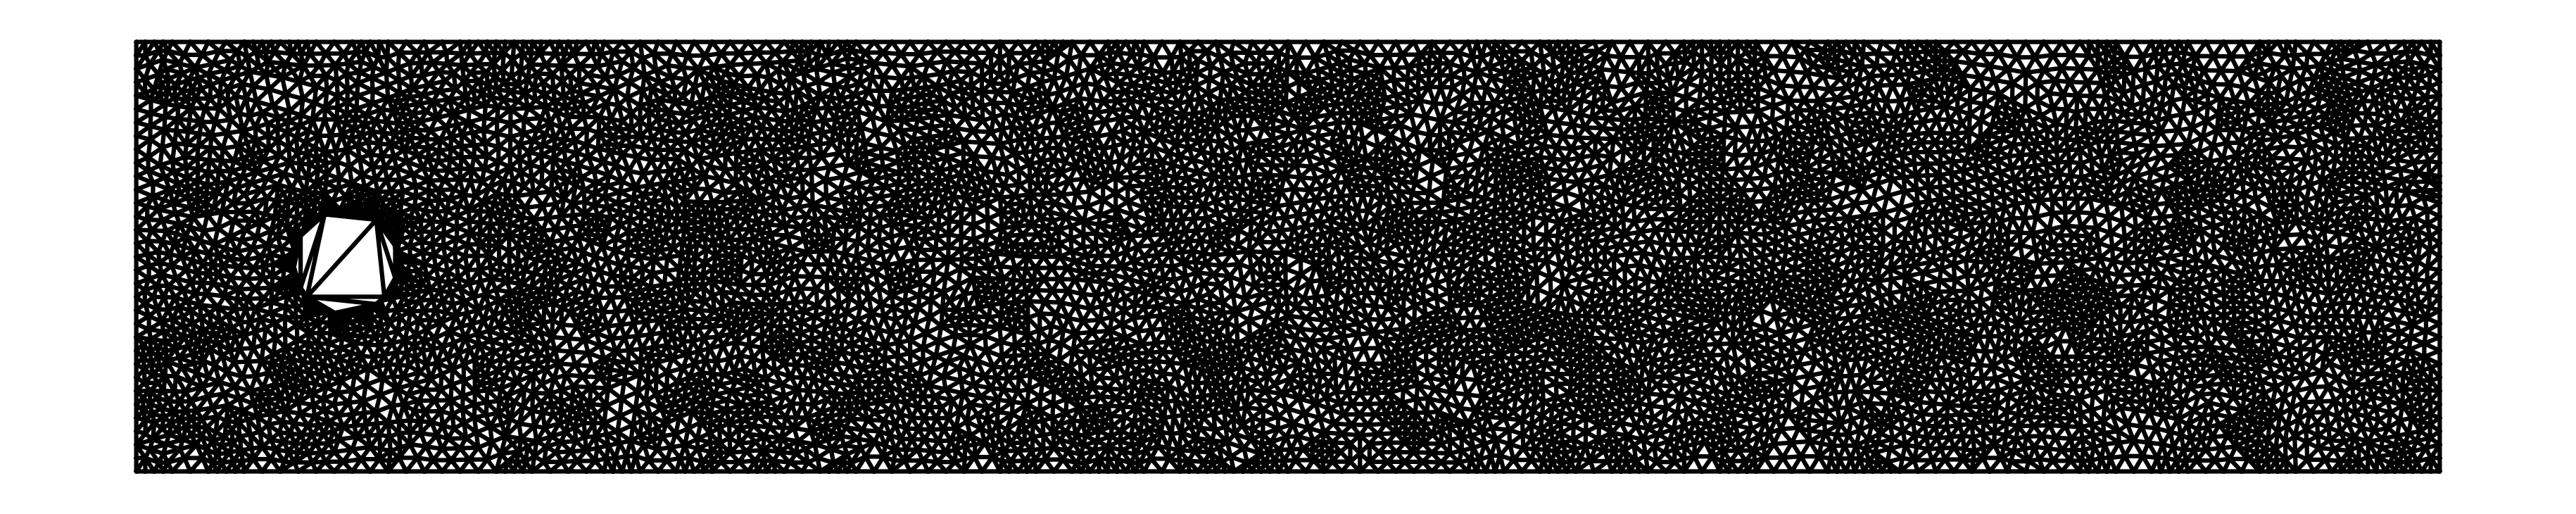

In [6]:

#mesh_scatter = axs[1,0].scatter(locations[:,0], locations[:,1], c = 'black', marker='.', s = 1)
#axs[1,0].set_aspect('equal')

flow_tri = triang(locations[:,0], locations[:,1])

fig_tri = plt.figure(figsize=(12,3.8), dpi=300)

ax_tri = fig_tri.add_axes([0,0,1,1])

ax_tri.triplot(flow_tri, color='black')

ax_tri.axis('off')
ax_tri.set_aspect('equal')

fig_tri.savefig(save_path / 'flow_mesh.jpeg', format='jpeg')


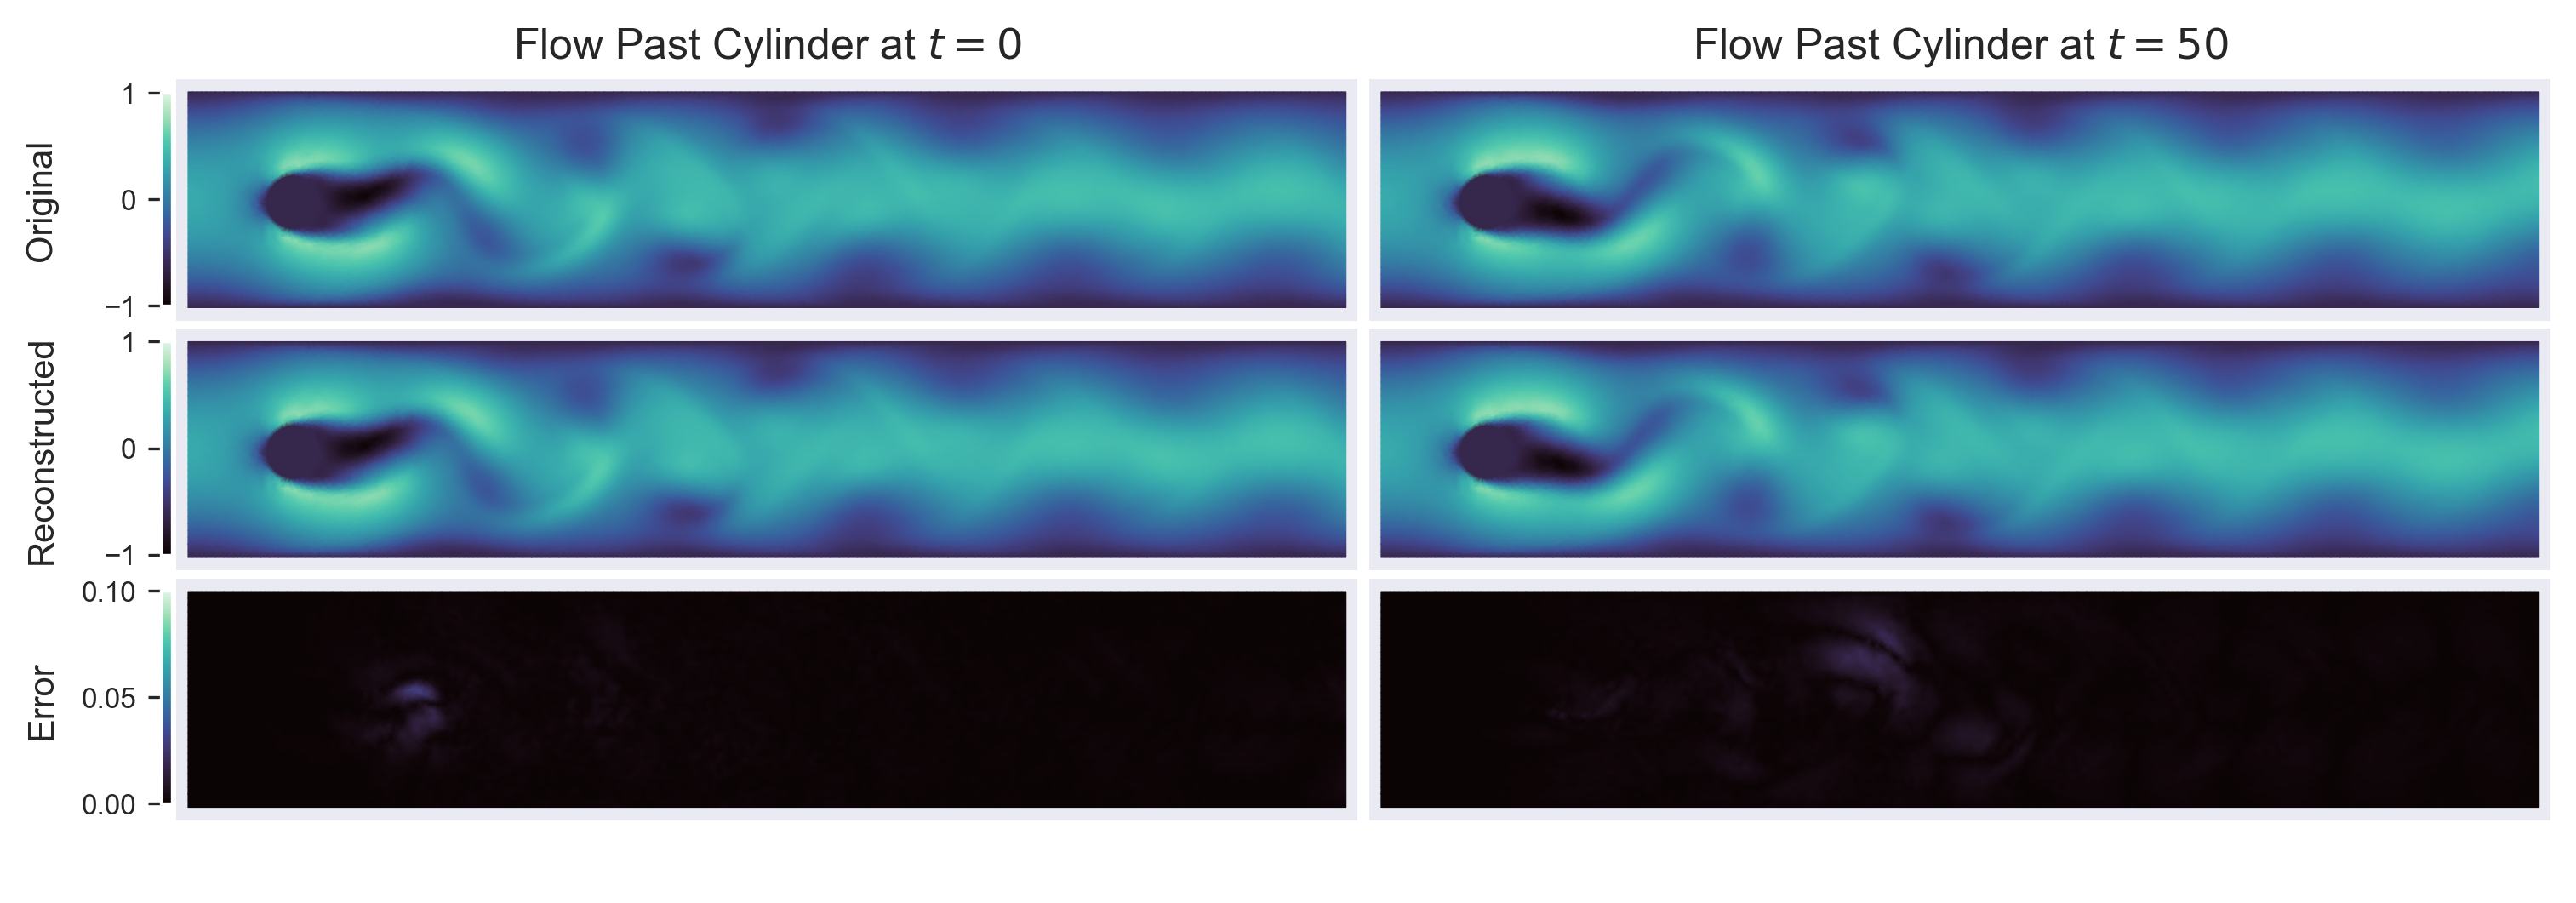

In [8]:
time_steps = [15 , 60]

max_disp = torch.max(dataset)
min_disp = torch.min(dataset)

max_disp = 1
min_disp = -1

my_map = seaborn.color_palette(palette='mako', as_cmap=True)


fig = plt.figure(figsize=(12,3.8), dpi=300)

axs = [fig.add_subplot(3,2,i+1) for i in range(6)]

max_x = torch.max(locations[:,0])
max_y = torch.max(locations[:,1])

flow_tri = triang(locations[:,0], locations[:,1])

map_it0 = axs[0].tripcolor(flow_tri, dataset[time_steps[0],0,:], facecolors=None, shading='gouraud', vmin=min_disp, vmax=max_disp, cmap= my_map)

map_it2 = axs[2].tripcolor(flow_tri, processed_data[time_steps[0],0,:], facecolors=None, shading='gouraud', vmin=min_disp, vmax=max_disp, cmap= my_map)

map_it4 = axs[4].tripcolor(flow_tri, difference_norm[time_steps[0],0,:], facecolors=None, shading='gouraud', vmin=0, vmax=0.1, cmap= my_map)

axs[1].tripcolor(flow_tri, dataset[time_steps[1],0,:], facecolors=None, shading='gouraud', vmin=min_disp, vmax=max_disp, cmap= my_map)

axs[3].tripcolor(flow_tri, processed_data[time_steps[1],0,:], facecolors=None, shading='gouraud', vmin=min_disp, vmax=max_disp, cmap= my_map)

axs[5].tripcolor(flow_tri, difference_norm[time_steps[1],0,:], facecolors=None, shading='gouraud', vmin=0, vmax=0.1, cmap= my_map)



bbox = axs[0].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0] -0.005, pos[1] - 0.01, pos[2]*0.01, pos[3] - 0.007])
plt.colorbar(map_it0, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)

bbox = axs[2].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0]-0.005, pos[1] + 0.005, pos[2]*0.01, pos[3] - 0.007])
plt.colorbar(map_it2, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)

bbox = axs[4].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0]-0.005, pos[1] + 0.02, pos[2]*0.01, pos[3] - 0.007])
plt.colorbar(map_it4, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)

for ax in axs:
    ax.label_outer()
    ax.set_aspect('equal')
    ax.margins(x=0.01, y = 0.06)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    #ax.set_axis_off()   

plt.subplots_adjust(hspace = 0.01, wspace = 0.01)

axs[0].set_title(r'Flow Past Cylinder at $t=0$')

axs[1].set_title(r'Flow Past Cylinder at $t=50$')


axs[0].yaxis.set_label_coords(-0.1,0.5)
axs[0].set_ylabel('Original')
axs[2].yaxis.set_label_coords(-0.1,0.5)
axs[2].set_ylabel('Reconstructed')
axs[4].yaxis.set_label_coords(-0.1,0.5)
axs[4].set_ylabel('Error')


fig.savefig(save_path / 'flow_viz_500.pdf', format='pdf', bbox_inches='tight')


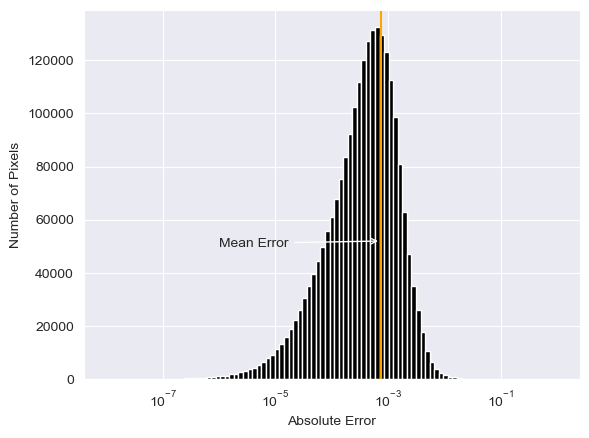

In [23]:

plt.hist(difference_norm.flatten(),bins=np.logspace(np.log10(1e-8),np.log10(1.0), 100), log=False, color='black')
plt.gca().set_xscale("log")
plt.ylabel('Number of Pixels')
plt.xlabel('Absolute Error')

plt.axvline(x = torch.mean(difference_norm), label = 'Mean Error', color='orange')
plt.annotate('Mean Error' , (torch.mean(difference_norm),5.2e4), xytext=(1e-6, 5e4), textcoords='data', arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

plt.savefig(save_path / 'flow_abs_error_histogram.pdf', format='pdf', bbox_inches='tight')


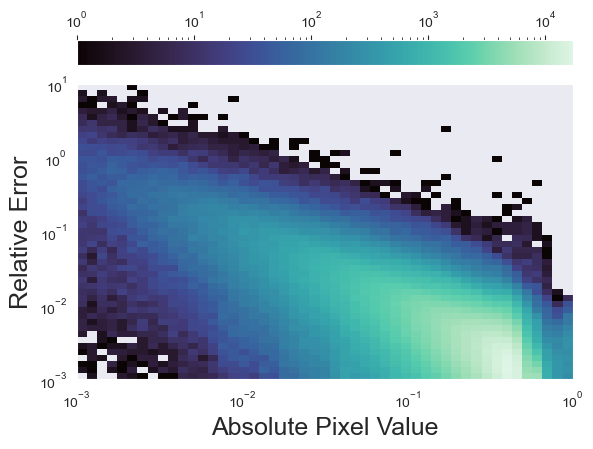

In [20]:
xbin = np.logspace(np.log10(1e-3),np.log10(1.), 50)
ybin = np.logspace(np.log10(1e-3),np.log10(10), 50)

plt.hist2d( torch.abs(dataset.flatten()).numpy(), relative_difference_norm.flatten().numpy(), bins=[xbin,ybin], norm = colors.LogNorm(), cmap=my_map)

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.colorbar(location='top')
plt.xlabel('Absolute Pixel Value', fontsize=18)
plt.ylabel('Relative Error', fontsize=18)

plt.savefig(save_path / 'flow_abs_rel_histogram.pdf', format='pdf')

<Figure size 640x480 with 0 Axes>

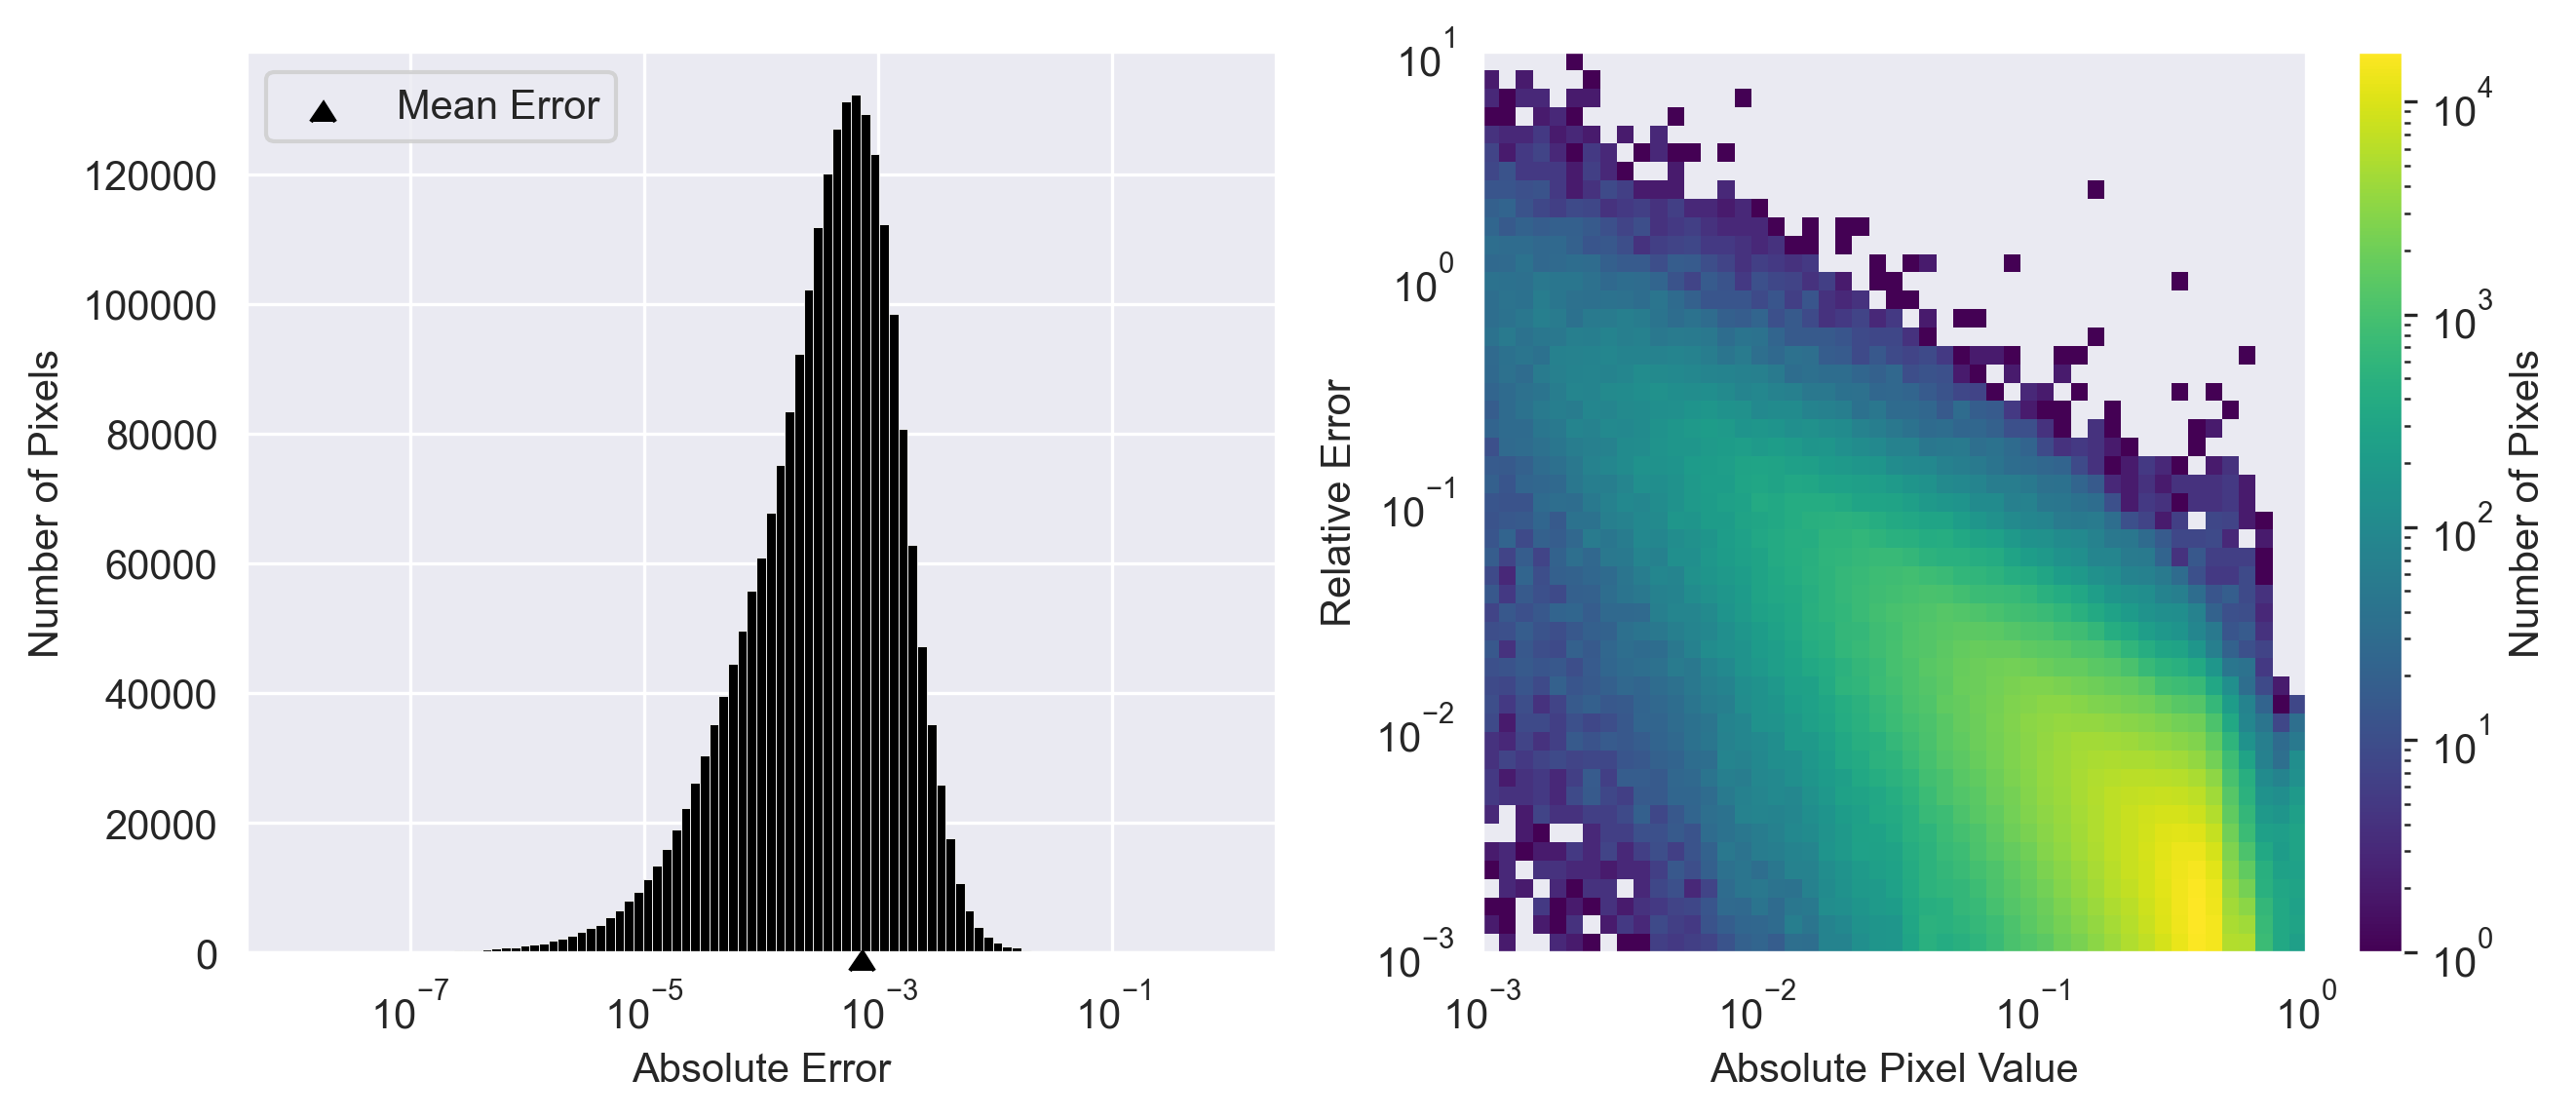

In [5]:
# subplot version of histograms

plt.subplots_adjust(hspace = 0.1, wspace = 0.01)

fig = plt.figure(figsize=(10,4), dpi=300)

haxs = [fig.add_subplot(1,2,i+1) for i in range(2)]

haxs[0].hist(difference_norm.flatten(),bins=np.logspace(np.log10(1e-8),np.log10(1.0), 100), log=False, color='black', linewidth=0.2)
haxs[0].set_xscale("log")
haxs[0].set(xlabel="Absolute Error",ylabel="Number of Pixels")

mean_mark = haxs[0].plot(torch.mean(difference_norm), 0, color = 'black', marker=6,label = 'Mean Error', zorder=10, clip_on=False, linestyle="None")

haxs[0].legend(loc='upper left')

hist_map = seaborn.color_palette(palette='viridis', as_cmap=True)

xbin = np.logspace(np.log10(1e-3),np.log10(1.), 50)
ybin = np.logspace(np.log10(1e-3),np.log10(10), 50)

h2 = haxs[1].hist2d( torch.abs(dataset.flatten()).numpy(), relative_difference_norm.flatten().numpy(), bins=[xbin,ybin], norm = colors.LogNorm(), cmap=hist_map)

haxs[1].set_xscale("log")
haxs[1].set_yscale("log")
haxs[1].set(xlabel="Absolute Pixel Value",ylabel="Relative Error")

fig.colorbar(h2[3], ax=haxs[1], location='right', label = 'Number of Pixels')

plt.savefig(save_path / 'error_analysis_plots_flow_500.pdf', format='pdf', bbox_inches='tight')


In [7]:
# print relevant numbers

print(sum(p.numel() for p in model.parameters() if p.requires_grad))


#compute average relative reconstruction error
dim = tuple([i for i in range(1, 3)])

n = torch.sqrt(torch.sum((dataset-processed_data)**2, dim=dim))
d = torch.sqrt(torch.sum((dataset)**2, dim=dim))

print(dim)
print(torch.mean(n/d))

print(dataset.shape)
print(n.shape)

834668
(1, 2)
tensor(0.0036)
torch.Size([300, 1, 7613])
torch.Size([300])
